In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, ParameterGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score

In [16]:
df = pd.read_csv('data_analysis/cleaned_data.csv')

In [17]:
features = df[['hour_created',
               'verified',
               'default_profile',
               'favourites_count',
               'followers_count',
               'friends_count',
               'statuses_count',
               'average_tweets_per_day',
               'account_age_days',
               ]]

In [28]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

In [ ]:
y = df['bot']

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=99)

In [48]:
param_grid = {
    'n_estimators': [x for x in range(50, 250, 10)],
    'contamination': [x/100.0 for x in range(5, 50, 5)] +['auto'],
    'bootstrap': [True, False],
    'n_jobs': [1, -1]
}

In [49]:
grid = ParameterGrid(param_grid)
results = []

In [ ]:
for params in grid:
    isolation_forest = IsolationForest(
        n_estimators=params['n_estimators'],
        contamination=params['contamination'],
        bootstrap=params['bootstrap'],
        n_jobs=params['n_jobs'],
        random_state=42
    )
    isolation_forest.fit(X_train)
    
    y_pred = isolation_forest.predict(X_test)
    y_pred_binary = [0 if pred == -1 else 1 for pred in y_pred]
    
    f1 = f1_score(y_test, y_pred_binary)
    
    results.append({
        'n_estimators': params['n_estimators'],
        'contamination': params['contamination'],
        'bootstrap': params['bootstrap'],
        'n_jobs': params['n_jobs'],
        'f1_score': f1
    })

In [51]:
results_df = pd.DataFrame(results)

In [68]:
results_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   n_estimators   800 non-null    int64  
 1   contamination  800 non-null    object 
 2   bootstrap      800 non-null    bool   
 3   n_jobs         800 non-null    int64  
 4   f1_score       800 non-null    float64
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 25.9+ KB


In [52]:
best_params = results_df.loc[results_df['f1_score'].idxmax()]
print("Best Parameters:")
print(best_params)

Best Parameters:
n_estimators          210
contamination        0.45
bootstrap           False
n_jobs                  1
f1_score         0.599411
Name: 752, dtype: object


In [54]:
results_df['contamination'] = results_df['contamination'].astype(str)

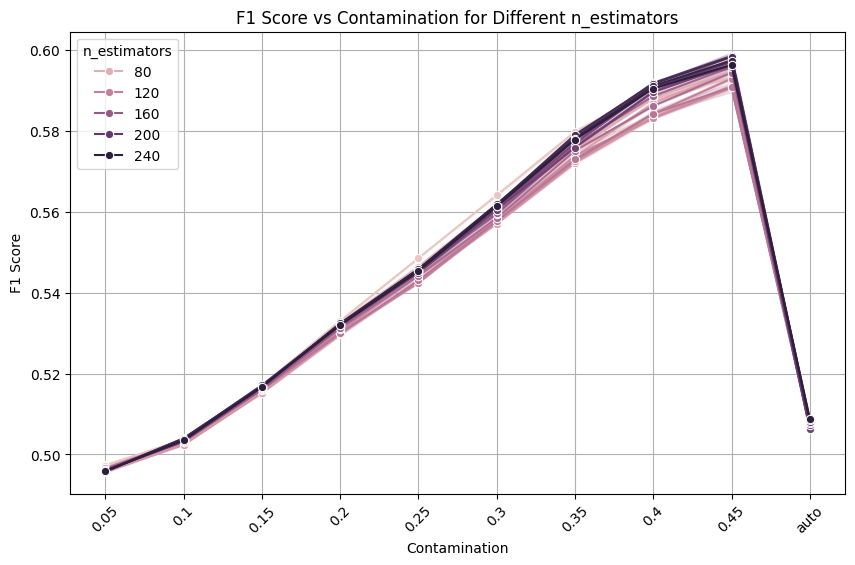

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=results_df,
    x='contamination',
    y='f1_score',
    hue='n_estimators',
    marker='o'
)
plt.title('F1 Score vs Contamination for Different n_estimators')
plt.xlabel('Contamination')
plt.ylabel('F1 Score')
plt.legend(title='n_estimators')
plt.grid()
plt.xticks(rotation=45)  
plt.show()

In [56]:
best_model = IsolationForest(n_estimators=210,
        contamination=0.45,
        bootstrap=False,
        n_jobs=1,
        random_state=42)

In [65]:
best_model.fit(X_train)

IsolationForest(contamination=0.45, n_estimators=210, n_jobs=1, random_state=42)

In [69]:
y_pred_test = best_model.predict(X_train)

In [ ]:
y_pred_test_binary = [0 if pred == -1 else 1 for pred in y_pred_test]

print("Confusion Matrix:")
print(confusion_matrix(y_train, y_pred_test_binary))

print("\nClassification Report:")
print(classification_report(y_train, y_pred_test_binary))

print("\nAccuracy:")
print(accuracy_score(y_train, y_pred_test_binary))

Confusion Matrix:
[[10097  7443]
 [ 1696  6970]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.58      0.69     17540
           1       0.48      0.80      0.60      8666

    accuracy                           0.65     26206
   macro avg       0.67      0.69      0.65     26206
weighted avg       0.73      0.65      0.66     26206


Accuracy:
0.6512630695260627


In [85]:
twi_test = pd.read_csv('api/twitter_zelenskiy_data.csv')

In [86]:
twi_test.head()

,screen_name,created_at,hour_created,verified_blur,default_profile,default_profile_image,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,account_age_days
0,kiyoiscute,2017-10-30,0,True,True,False,75731,108820,961,5780,2.22,2602
1,UnionAlgerienne,2022-12-29,10,True,True,False,1065,24551,0,1075,1.50,716
2,Dialog_UA,2014-03-20,15,True,False,False,9889,80714,1013,322270,82.17,3922
3,UA_EN_TCG,2023-11-29,5,True,True,False,5,10197,9,855,2.24,381
4,ukraineuachina,2022-09-20,11,False,True,False,6,1637,0,601,0.74,816


In [87]:
twi_test['verified'] = twi_test['verified_blur'].astype(int)
twi_test.drop('verified_blur', axis=1, inplace=True)
twi_test['default_profile'] = twi_test['default_profile'].astype(int)
twi_test['default_profile_image'] = twi_test['default_profile_image'].astype(int)
twi_test['hour_created'] = pd.to_datetime(twi_test['created_at']).dt.hour

In [88]:
twi_test = twi_test[['hour_created',
               'verified',
               'default_profile',
               'favourites_count',
               'followers_count',
               'friends_count',
               'statuses_count',
               'average_tweets_per_day',
               'account_age_days',
               ]]

In [89]:
twi_test.head()

,hour_created,verified,default_profile,favourites_count,followers_count,friends_count,statuses_count,average_tweets_per_day,account_age_days
0,0,1,1,75731,108820,961,5780,2.22,2602
1,0,1,1,1065,24551,0,1075,1.50,716
2,0,1,0,9889,80714,1013,322270,82.17,3922
3,0,1,1,5,10197,9,855,2.24,381
4,0,0,1,6,1637,0,601,0.74,816


In [90]:
twi_pred = best_model.predict(twi_test)

/home/marta/ucu/ai/project/.venv/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but IsolationForest was fitted without feature names
  warnings.warn(


In [93]:
twi_pred = ['bot' if pred == -1 else 'user' for pred in twi_pred]
twi_pred

['user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user',
 'user']